In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv('train_cleaned.csv')
test_df = pd.read_csv('test_cleaned.csv')
val_df = pd.read_csv('val_cleaned.csv')

In [ ]:
custom_map = {"sad": 0, "happy": 1, "angry": 2, "calm": 3}

In [ ]:
train_df['mood_num'] = train_df['mood'].map(custom_map)
test_df['mood_num'] = test_df['mood'].map(custom_map)
val_df['mood_num'] = val_df['mood'].map(custom_map)

In [ ]:
print("Train class counts:\n", train_df['mood'].value_counts(normalize=True))
print("\nTest class counts:\n", test_df['mood'].value_counts(normalize=True))
print("\nValidation class counts:\n", val_df['mood'].value_counts(normalize=True))

Train class counts:
 mood
calm     0.450465
happy    0.352575
sad      0.098515
angry    0.098445
Name: proportion, dtype: float64

Test class counts:
 mood
calm     0.454160
happy    0.342188
angry    0.104593
sad      0.099059
Name: proportion, dtype: float64

Validation class counts:
 mood
calm     0.444219
happy    0.360686
sad      0.100498
angry    0.094597
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Function to undersample a dataset
def balance_dataset(df, target_col='mood'):
    # Find the minority class count
    min_count = df[target_col].value_counts().min()

    # List to store resampled dataframes
    balanced_dfs = []

    # Resample each class to min_count
    for mood in df[target_col].unique():
        mood_df = df[df[target_col] == mood]
        mood_resampled = resample(mood_df,
                                  replace=False,       # undersample
                                  n_samples=min_count,
                                  random_state=42)
        balanced_dfs.append(mood_resampled)

    # Combine all classes
    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

# Apply to datasets
train_balanced = balance_dataset(train_df)
test_balanced = balance_dataset(test_df)
val_balanced = balance_dataset(val_df)

# Save the balanced datasets
train_balanced.to_csv('train_balanced.csv', index=False)
test_balanced.to_csv('test_balanced.csv', index=False)
val_balanced.to_csv('val_balanced.csv', index=False)

# Check new class distribution
print("Balanced Train class counts:\n", train_balanced['mood'].value_counts(normalize=True))
print("\nBalanced Test class counts:\n", test_balanced['mood'].value_counts(normalize=True))
print("\nBalanced Validation class counts:\n", val_balanced['mood'].value_counts(normalize=True))


Balanced Train class counts:
 mood
happy    0.25
sad      0.25
calm     0.25
angry    0.25
Name: proportion, dtype: float64

Balanced Test class counts:
 mood
sad      0.25
angry    0.25
calm     0.25
happy    0.25
Name: proportion, dtype: float64

Balanced Validation class counts:
 mood
calm     0.25
angry    0.25
sad      0.25
happy    0.25
Name: proportion, dtype: float64


In [ ]:
# Function to print dataset sizes
def print_dataset_sizes(df, name="Dataset"):
    print(f"\n{name} size: {len(df)} rows")
    print(df['mood'].value_counts())
    print(df['mood'].value_counts(normalize=True))

# Check original dataset sizes
print_dataset_sizes(train_df, "Original Train")
print_dataset_sizes(test_df, "Original Test")
print_dataset_sizes(val_df, "Original Validation")

# Check balanced dataset sizes
print_dataset_sizes(train_balanced, "Balanced Train")
print_dataset_sizes(test_balanced, "Balanced Test")
print_dataset_sizes(val_balanced, "Balanced Validation")



Original Train size: 43222 rows
mood
calm     19470
happy    15239
sad       4258
angry     4255
Name: count, dtype: int64
mood
calm     0.450465
happy    0.352575
sad      0.098515
angry    0.098445
Name: proportion, dtype: float64

Original Test size: 5421 rows
mood
calm     2462
happy    1855
angry     567
sad       537
Name: count, dtype: int64
mood
calm     0.454160
happy    0.342188
angry    0.104593
sad      0.099059
Name: proportion, dtype: float64

Original Validation size: 5423 rows
mood
calm     2409
happy    1956
sad       545
angry     513
Name: count, dtype: int64
mood
calm     0.444219
happy    0.360686
sad      0.100498
angry    0.094597
Name: proportion, dtype: float64

Balanced Train size: 17020 rows
mood
happy    4255
sad      4255
calm     4255
angry    4255
Name: count, dtype: int64
mood
happy    0.25
sad      0.25
calm     0.25
angry    0.25
Name: proportion, dtype: float64

Balanced Test size: 2148 rows
mood
sad      537
angry    537
calm     537
happy    537
Na

In [ ]:
import pandas as pd
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
train_df = pd.read_csv('train_balanced.csv')
val_df = pd.read_csv('val_balanced.csv')
test_df = pd.read_csv('test_balanced.csv')

In [ ]:
train_df.rename(columns={'mood_num': 'label'}, inplace=True)
val_df.rename(columns={'mood_num': 'label'}, inplace=True)
test_df.rename(columns={'mood_num': 'label'}, inplace=True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=64):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
train_dataset = EmotionDataset(train_df, tokenizer)
val_dataset = EmotionDataset(val_df, tokenizer)
test_dataset = EmotionDataset(test_df, tokenizer)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

print("✅ Balanced datasets loaded and tokenized!")
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

✅ Balanced datasets loaded and tokenized!
Train batches: 1064, Validation batches: 129


In [ ]:
import torch
from torch import nn
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=4  # sad, happy, angry, calm
)
model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 12
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
    return total_loss / len(data_loader)

In [ ]:
def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    val_loss, val_acc = eval_epoch(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/12


Train Loss: 0.9226 | Val Loss: 0.8207 | Val Acc: 0.6847

Epoch 2/12


Train Loss: 0.6662 | Val Loss: 0.8160 | Val Acc: 0.6905

Epoch 3/12


Train Loss: 0.4551 | Val Loss: 0.9152 | Val Acc: 0.6798

Epoch 4/12


Train Loss: 0.2495 | Val Loss: 1.1676 | Val Acc: 0.6823

Epoch 5/12


Train Loss: 0.1329 | Val Loss: 1.3898 | Val Acc: 0.6691

Epoch 6/12


Train Loss: 0.0807 | Val Loss: 1.5975 | Val Acc: 0.6594

Epoch 7/12


Train Loss: 0.0517 | Val Loss: 1.7664 | Val Acc: 0.6598

Epoch 8/12


Train Loss: 0.0347 | Val Loss: 1.7972 | Val Acc: 0.6696

Epoch 9/12


Train Loss: 0.0280 | Val Loss: 1.8602 | Val Acc: 0.6676

Epoch 10/12


Train Loss: 0.0176 | Val Loss: 1.9438 | Val Acc: 0.6652

Epoch 11/12


Train Loss: 0.0114 | Val Loss: 2.0267 | Val Acc: 0.6696

Epoch 12/12


Train Loss: 0.0094 | Val Loss: 2.0382 | Val Acc: 0.6701


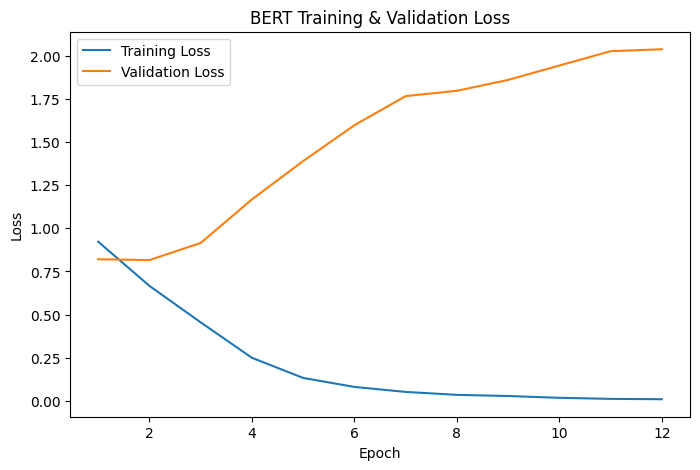

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BERT Training & Validation Loss')
plt.legend()
plt.show()

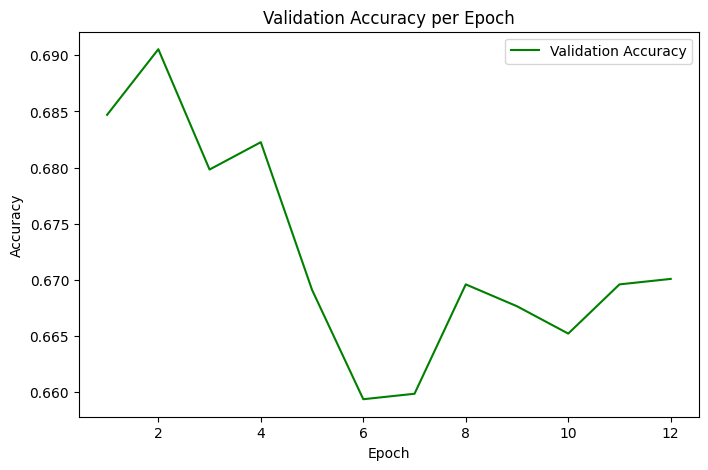

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.show()

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Save model
model.save_pretrained("bert_emotion_model")  # creates a folder with config + weights

# Save tokenizer
tokenizer.save_pretrained("bert_emotion_model")  # saves tokenizer files in same folder

print("✅ Model and tokenizer saved successfully!")


✅ Model and tokenizer saved successfully!
